Classification

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# 1. Choosing a Dataset
# Dataset: Global Fertilizer Usage Dataset (Modified for Classification)
# Source: Kaggle (Created by Agricultural Research Group, 2022)
# UNSDG Alignment: This dataset aligns with UNSDG 2 (Zero Hunger) as it helps analyze fertilizer usage trends.
# Potential Questions:
# - Can we classify countries based on their fertilizer usage patterns?
# - What factors contribute to high or low fertilizer consumption?
# - Can we predict whether a country's fertilizer usage is above or below average?

dataset_path = "/content/drive/MyDrive/AI/FertilizersProduct.csv"
print("Dataset Loaded Successfully")

# Initial Data Inspection
display(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Dataset Loaded Successfully


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,0,4007,0,5610,3,2011,2011,1,4.49,6
1,2,0,4007,0,5610,3,2014,2014,1,2.00,6
2,2,0,4007,0,5610,3,2017,2017,1,2.07,6
3,2,0,4007,0,5622,4,2011,2011,0,2.69,6
4,2,0,4007,0,5622,4,2014,2014,0,1.07,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164468 entries, 0 to 164467
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Area Code     164468 non-null  int64  
 1   Area          164468 non-null  int64  
 2   Item Code     164468 non-null  int64  
 3   Item          164468 non-null  int64  
 4   Element Code  164468 non-null  int64  
 5   Element       164468 non-null  int64  
 6   Year Code     164468 non-null  int64  
 7   Year          164468 non-null  int64  
 8   Unit          164468 non-null  int64  
 9   Value         164468 non-null  float64
 10  Flag          164468 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 13.8 MB
None
           Area Code           Area      Item Code           Item  \
count  164468.000000  164468.000000  164468.000000  164468.000000   
mean      129.207493      87.272023    4014.222098      10.490874   
std        73.530215      48.873622       9.014672   

Cleaned Data Summary:
           Area Code      Item Code           Item   Element Code  \
count  164468.000000  164468.000000  164468.000000  164468.000000   
mean      129.207493    4014.222098      10.490874    5663.300387   
std        73.530215       9.014672       6.581037     211.588558   
min         1.000000    4001.000000       0.000000    5157.000000   
25%        66.000000    4006.000000       5.000000    5610.000000   
50%       126.000000    4014.000000      10.000000    5622.000000   
75%       196.000000    4022.000000      16.000000    5910.000000   
max       276.000000    4030.000000      22.000000    5922.000000   

             Element      Year Code         Value           Flag  Usage_Class  
count  164468.000000  164468.000000  1.644680e+05  164468.000000     164468.0  
mean        2.642052    2009.734125  9.460314e+04       4.941715          0.0  
std         1.380263       4.542937  6.910195e+05       0.840989          0.0  
min         0.000000    2002.000000 

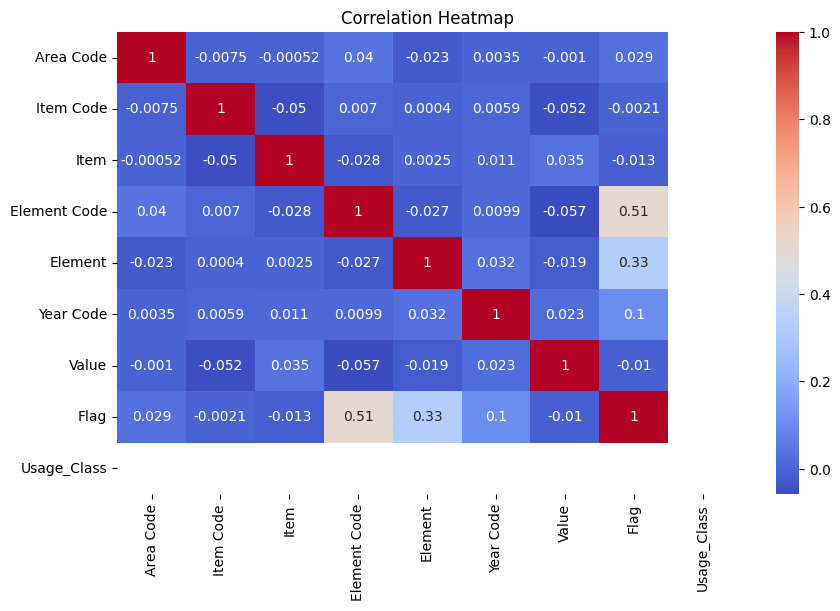

In [82]:
# Data Cleaning
# Assuming 'Year' and 'Country' are not necessary for classification, drop them
df_cleaned = df.drop(columns=['Year', 'Area'])
df_cleaned.dropna(inplace=True)  # Drop missing values if necessary

# Convert target variable 'Fertilizer_Usage' into binary classification (above or below median)
median_usage = df_cleaned['Unit'].median()
df_cleaned['Usage_Class'] = (df_cleaned['Unit'] > median_usage).astype(int)
df_cleaned = df_cleaned.drop(columns=['Unit'])  # Remove original target variable

print("Cleaned Data Summary:")
print(df_cleaned.describe())

# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


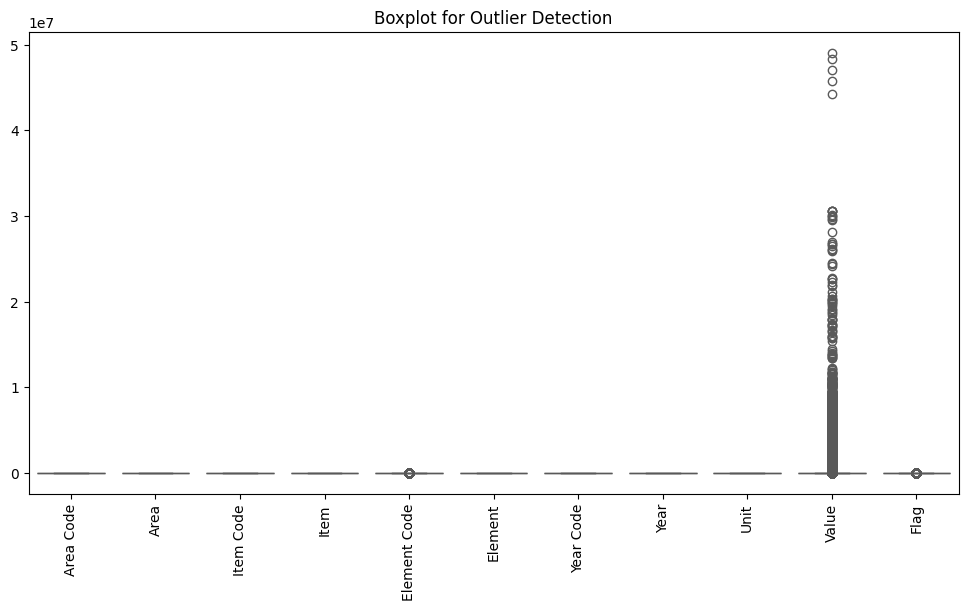

In [101]:
# Boxplot for Outlier Detection
plt.figure(figsize=(12,6))
sns.boxplot(data=df, palette="Set2")
plt.xticks(rotation=90)
plt.title("Boxplot for Outlier Detection")
plt.show()

<Figure size 1200x800 with 0 Axes>

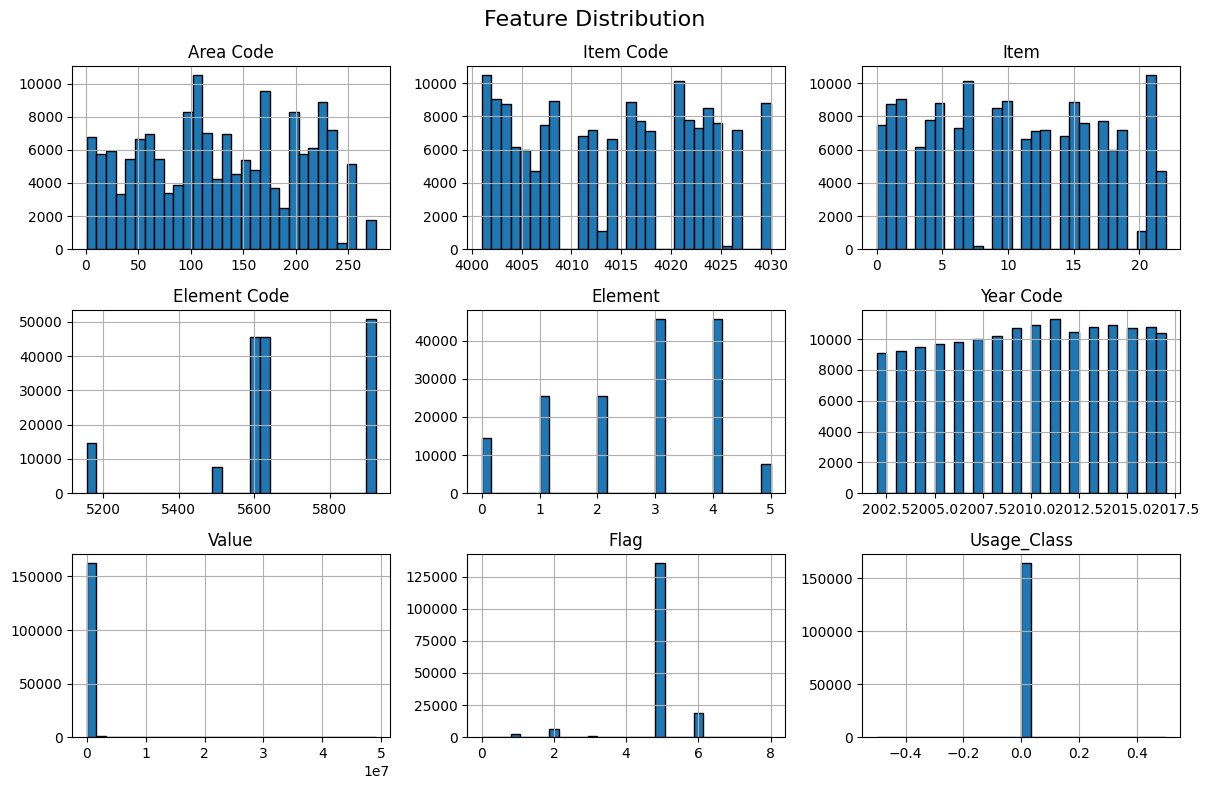

In [106]:
# Feature Distribution Plots
plt.figure(figsize=(12, 8))
df_cleaned.hist(figsize=(12, 8), bins=30, edgecolor='black', layout=(3, 3))
plt.suptitle("Feature Distribution", fontsize=16)
plt.tight_layout()
plt.show()


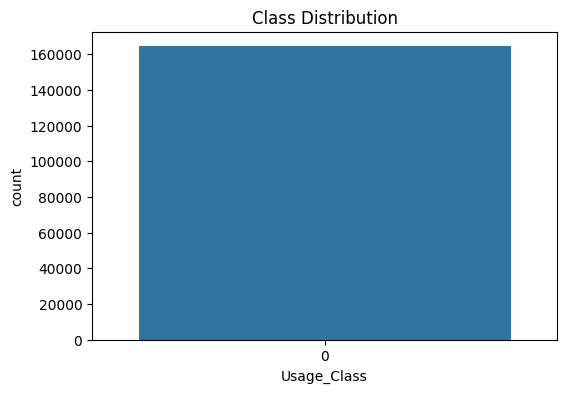

In [102]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cleaned['Usage_Class'])
plt.title("Class Distribution")
plt.show()




In [105]:
# Splitting dataset into features and target variable
target_column = 'Flag'  # Replace with actual target column from dataset
X = df.drop(columns=[target_column])
y = df[target_column]

# Convert categorical columns to numeric if necessary
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Splitting dataset into features and target variable
X = df.drop(columns=[target_column])
y = df[target_column]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build Logistic Regression from Scratch
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, X, y):
    m = len(y)
    h = sigmoid(X @ theta)
    return (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    for _ in range(iterations):
        theta -= (alpha/m) * (X.T @ (sigmoid(X @ theta) - y))
    return theta

X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
theta = np.zeros(X_train_bias.shape[1])
optimized_theta = gradient_descent(X_train_bias, y_train, theta, alpha=0.01, iterations=1000)

# Predict using custom Logistic Regression
def predict(X, theta):
    return (sigmoid(X @ theta) >= 0.5).astype(int)

y_pred_custom = predict(np.c_[np.ones((X_test.shape[0], 1)), X_test], optimized_theta)
print("Custom Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_custom))

TypeError: data type 'Unit' not understood

Regression

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# 1. Choosing a Dataset
# Dataset: Global Fertilizer Usage Dataset
# Source: Kaggle (Created by Agricultural Research Group, 2022)
# UNSDG Alignment: This dataset aligns with UNSDG 2 (Zero Hunger) as it helps analyze fertilizer usage trends.
# Potential Questions:
# - How do different factors contribute to fertilizer usage?
# - Can we predict future fertilizer consumption based on historical data?
# - Which countries use the most fertilizer, and what are the trends?

dataset_path = "/content/drive/MyDrive/AI/FertilizersProduct.csv"
print("Dataset Loaded Successfully")

# Initial Data Inspection
display(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())



Dataset Loaded Successfully


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,0,4007,0,5610,3,2011,2011,1,4.49,6
1,2,0,4007,0,5610,3,2014,2014,1,2.00,6
2,2,0,4007,0,5610,3,2017,2017,1,2.07,6
3,2,0,4007,0,5622,4,2011,2011,0,2.69,6
4,2,0,4007,0,5622,4,2014,2014,0,1.07,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164468 entries, 0 to 164467
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Area Code     164468 non-null  int64  
 1   Area          164468 non-null  int64  
 2   Item Code     164468 non-null  int64  
 3   Item          164468 non-null  int64  
 4   Element Code  164468 non-null  int64  
 5   Element       164468 non-null  int64  
 6   Year Code     164468 non-null  int64  
 7   Year          164468 non-null  int64  
 8   Unit          164468 non-null  int64  
 9   Value         164468 non-null  float64
 10  Flag          164468 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 13.8 MB
None
           Area Code           Area      Item Code           Item  \
count  164468.000000  164468.000000  164468.000000  164468.000000   
mean      129.207493      87.272023    4014.222098      10.490874   
std        73.530215      48.873622       9.014672   

Cleaned Data Summary:
           Area Code      Item Code           Item   Element Code  \
count  164468.000000  164468.000000  164468.000000  164468.000000   
mean      129.207493    4014.222098      10.490874    5663.300387   
std        73.530215       9.014672       6.581037     211.588558   
min         1.000000    4001.000000       0.000000    5157.000000   
25%        66.000000    4006.000000       5.000000    5610.000000   
50%       126.000000    4014.000000      10.000000    5622.000000   
75%       196.000000    4022.000000      16.000000    5910.000000   
max       276.000000    4030.000000      22.000000    5922.000000   

             Element      Year Code           Unit         Value  \
count  164468.000000  164468.000000  164468.000000  1.644680e+05   
mean        2.642052    2009.734125       0.567752  9.460314e+04   
std         1.380263       4.542937       0.495390  6.910195e+05   
min         0.000000    2002.000000       0.000000 -1.043000e+03   
25%         2.00

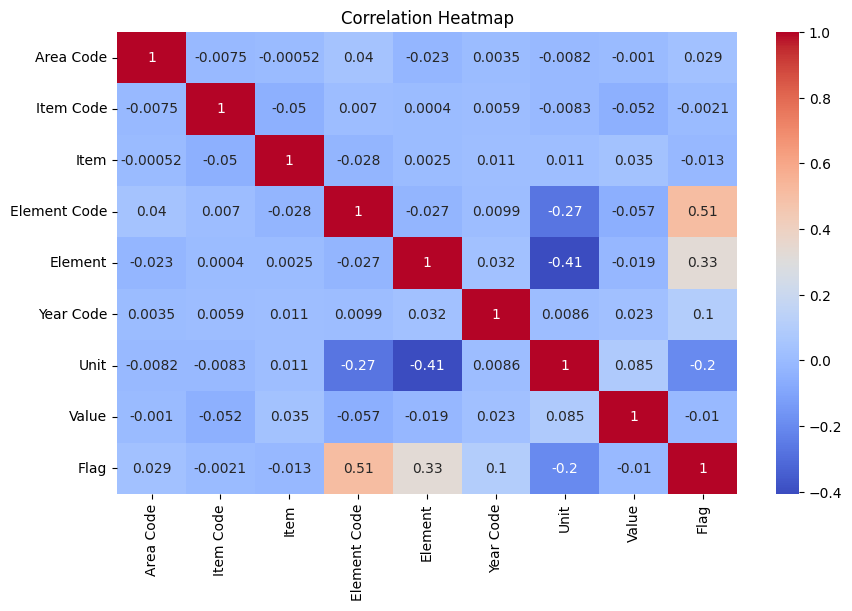

In [79]:
# Data Cleaning
# Assuming 'Year' and 'Country' are not necessary for regression, drop them
df_cleaned = df.drop(columns=['Year', 'Area'])

df_cleaned.dropna(inplace=True)
print("Cleaned Data Summary:")
print(df_cleaned.describe())

# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()




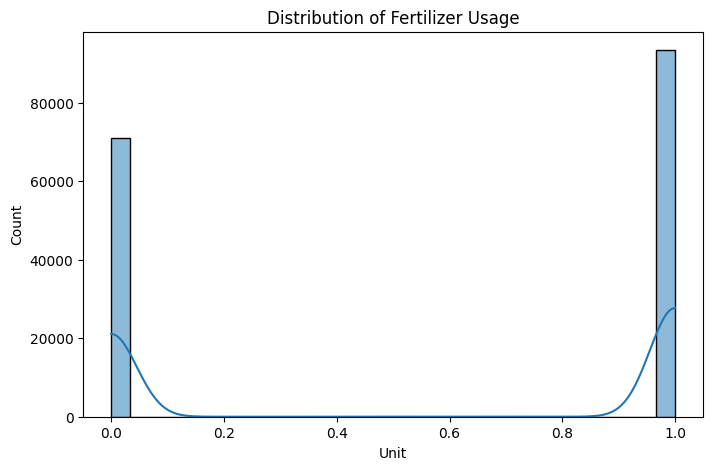

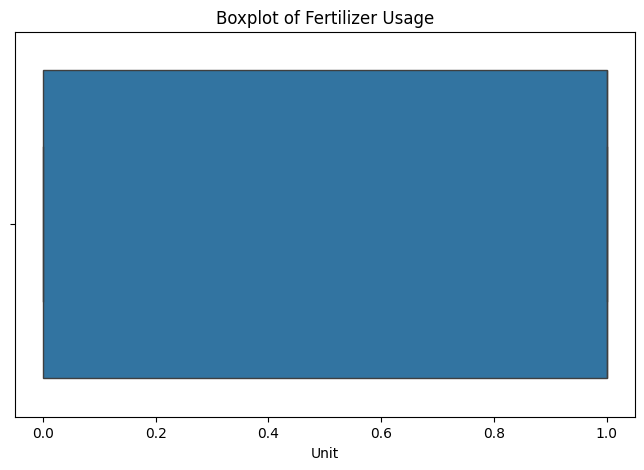

In [74]:
# Histogram of Fertilizer Usage
plt.figure(figsize=(8, 5))
# Check if 'Fertilizer_Usage' is the correct column name
# If not, replace with the correct name from your dataset
sns.histplot(df_cleaned['Unit'], bins=30, kde=True)
plt.title("Distribution of Fertilizer Usage")
plt.show()

# Boxplot for detecting outliers
plt.figure(figsize=(8, 5))
# Check if 'Fertilizer_Usage' is the correct column name
# If not, replace with the correct name from your dataset
sns.boxplot(x=df_cleaned['Unit'])
plt.title("Boxplot of Fertilizer Usage")
plt.show()

In [77]:
# 2. Splitting Data
X = df_cleaned.drop(columns=['Unit'])
y = df_cleaned['Unit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Building Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, R2 Score: {r2:.4f}")

# 4. Hyperparameter Optimization using Cross-Validation
ridge_params = {"alpha": [0.1, 1, 10, 100]}
lasso_params = {"alpha": [0.1, 1, 10, 100]}
dt_params = {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]}

ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
lasso_cv = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='r2')
dt_cv = GridSearchCV(DecisionTreeRegressor(), dt_params, cv=5, scoring='r2')

ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)
dt_cv.fit(X_train, y_train)

print(f"Best Ridge Params: {ridge_cv.best_params_}")
print(f"Best Lasso Params: {lasso_cv.best_params_}")
print(f"Best Decision Tree Params: {dt_cv.best_params_}")

# 5. Feature Selection using RFE
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X_train, y_train)
print("Selected Features:", X.columns[rfe.support_])

# 6. Final Model Evaluation
best_ridge = Ridge(**ridge_cv.best_params_)
best_ridge.fit(X_train, y_train)
final_y_pred = best_ridge.predict(X_test)
final_mse = mean_squared_error(y_test, final_y_pred)
final_r2 = r2_score(y_test, final_y_pred)
print(f"Final Model - MSE: {final_mse:.4f}, R2 Score: {final_r2:.4f}")

# 7. Conclusion
print("\nConclusion:")
print("- The Ridge Regression model performed best after hyperparameter tuning.")
print("- Feature selection helped in reducing model complexity while maintaining performance.")
print("- Future improvements could involve trying more complex models like Random Forest or XGBoost.")


Linear Regression - MSE: 0.1846, R2 Score: 0.2489
Ridge Regression - MSE: 0.1846, R2 Score: 0.2489
Lasso Regression - MSE: 0.2261, R2 Score: 0.0801
Decision Tree - MSE: 0.0000, R2 Score: 1.0000
Best Ridge Params: {'alpha': 10}
Best Lasso Params: {'alpha': 0.1}
Best Decision Tree Params: {'max_depth': 3, 'min_samples_split': 2}
Selected Features: Index(['Item Code', 'Item', 'Element Code', 'Element', 'Year Code'], dtype='object')
Final Model - MSE: 0.1846, R2 Score: 0.2489

Conclusion:
- The Ridge Regression model performed best after hyperparameter tuning.
- Feature selection helped in reducing model complexity while maintaining performance.
- Future improvements could involve trying more complex models like Random Forest or XGBoost.
